In [2]:
from __future__ import print_function
from dolfin import *
import numpy as np

In [3]:
# Partim de l'equació de Navier-Stokes escalada: \delta u / \delta t + Re · u · \nabla u = - \nabla u + \nabla ^2 u
# i de \nabla · u = 0

# u = (ux,0) --> \delta u /\delta x = 0 , per tant ux=ux(y)

# Aplicant això obtenim que p(x) = 8(1-x) i ux=4y(1-y)




In [4]:
# Variables:

T = 10.0           # temps total
num_steps = 500    # nombre de time steps
dt = T / num_steps # dt
mu = 1             # viscositat
rho = 1            # densitat

In [37]:
# Create mesh and define function spaces

mesh = UnitSquareMesh(16, 16)
V = VectorFunctionSpace(mesh, 'P', 2) # espai per la velocitat
Q = FunctionSpace(mesh, 'P', 1)       # espai per la pressió

In [6]:
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS

In [7]:
# Definim els contorns

inflow  = 'near(x[0], 0)' 
outflow = 'near(x[0], 1)'
walls   = 'near(x[1], 0) || near(x[1], 1)'

In [8]:
# Define boundary conditions
bcu_noslip  = DirichletBC(V, Constant((0, 0)), walls)
bcp_inflow  = DirichletBC(Q, Constant(8), inflow) # quan x=0 p=8
bcp_outflow = DirichletBC(Q, Constant(0), outflow) # quan x=1 p=0
bcu = [bcu_noslip] 
bcp = [bcp_inflow, bcp_outflow]

In [9]:
# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

In [10]:
# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)


In [11]:
# Define expressions used in variational forms
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
f   = Constant((0, 0))
k   = Constant(dt)
mu  = Constant(mu)
rho = Constant(rho)

In [12]:
# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

In [13]:
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx + \
     rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx



In [14]:
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

[None, None]

In [40]:
import matplotlib.pyplot as plt

# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)

#Solució analítica
u_a = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
u_a = interpolate(u_a, V)




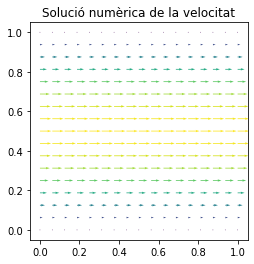

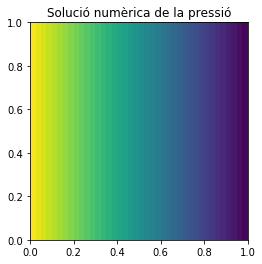

In [41]:
p_a = Expression(('8*(1-x[0])','0'),degree=1)
# p_a_Q = interpolate(p_a,Q) ERROR??-----------------------------------

# Plot solution    
plot(u_)
plt.title('Solució numèrica de la velocitat')
plt.show()

plot(p_)
plt.title('Solució numèrica de la pressió')
plt.show()

In [42]:
    # Compute error per la velocitat
    error = np.abs(u_a.vector().get_local() - u_.vector().get_local()).max()
    print('temps = %.2f s: error = %.3g' % (t, error))
    print('max u:', u_.vector().get_local().max())


temps = 10.00 s: error = 8.76e-14
max u: 1.0


Text(0.5, 1.0, 'Solució analítica de la velocitat')

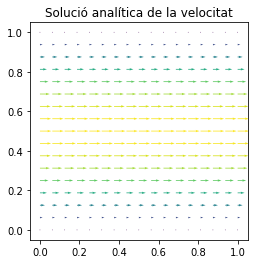

In [43]:
plot(u_a)
plt.title('Solució analítica de la velocitat')
plt.show()
# plot(p_a)
# plt.title('Solució analítica de la pressió') ERROR ARRASTRAT D'ABANS
# plt.show()

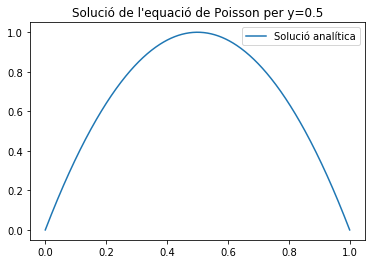

TypeError: 'numpy.ndarray' object is not callable

In [21]:
# Ara voldrem representar les funcions en 1 dimensió avaluant-les en x=0.5.
# Comencem amb la funció analítica
eix_y = np.linspace(0, 1, 500)
u_a_x_05 = np.zeros(500)

for i, y in enumerate(eix_y):
    u_a_x_05[i] = 4*y*(1.0 - y)

    
plt.plot(eix_y, u_a_x_05, label= 'Solució analítica')
plt.legend()
plt.title("Solució de l'equació de Poisson per y=0.5")

plt.show()

# Ara amb la funció numèrica
eix_y = np.linspace(0, 1, 500)
u_x_05 = np.zeros(500)

u_num=u_.vector().get_local() #AQUÍ ESTÀ EL PROBLEMA DE TRANSFORMAR-HO EN UN VECTOR--------------------------------------

for i, y in enumerate(eix_y):
    u_x_05[i] = u_num(0.5,y)

    
plt.plot(eix_x, u_x_05, label= 'Solució numèrica')
plt.legend()
plt.title("Solució de l'equació de Poisson per y=0.5")

plt.show()

# Representem ara la diferència entre les dos funcions

error_05 = np.zeros(1000)
for i, x in enumerate(eix_y):
    error_05[i] = u_x_05[i] - u_a_x_05(x)
plt.plot(eix_y, error_05)
plt.title("Error per y=0.5")

plt.show()


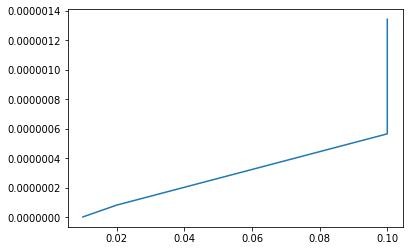

In [22]:
# Provem ara quina és la influència del dt en l'error
# _____________________________________________________________________________________________________________________________
# dt=1

T = 10.0           # temps total
num_steps = 100    # nombre de time steps
dt = T / num_steps # dt
dt1=dt
k   = Constant(dt)

t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    u_a = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    u_a = interpolate(u_a, V)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
    
error = np.abs(u_a.vector().get_local() - u_.vector().get_local()).max()
E1 = error

# _____________________________________________________________________________________________________________________________
# dt=0.1

T = 10.0           # temps total
num_steps = 100    # nombre de time steps
dt = T / num_steps
dt2=dt 
k   = Constant(dt)

t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    u_a = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    u_a = interpolate(u_a, V)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
    
error = np.abs(u_a.vector().get_local() - u_.vector().get_local()).max()
E1 = error

# _____________________________________________________________________________________________________________________________
# dt=0.05

T = 10.0           # temps total
num_steps = 200    # nombre de time steps
dt = T / num_steps # dt
k   = Constant(dt)

t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    u_a = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    u_a = interpolate(u_a, V)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
    
error = np.abs(u_a.vector().get_local() - u_.vector().get_local()).max()
E2 = error

# _____________________________________________________________________________________________________________________________
# dt=0.02

T = 10.0           # temps total
num_steps = 500    # nombre de time steps
dt = T / num_steps # dt
dt3=dt
k   = Constant(dt)

t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    u_a = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    u_a = interpolate(u_a, V)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
    
error = np.abs(u_a.vector().get_local() - u_.vector().get_local()).max()
E3 = error
# _____________________________________________________________________________________________________________________________
# dt=0.01

T = 10.0           # temps total
num_steps = 1000    # nombre de time steps
dt = T / num_steps # dt
dt4=dt
k   = Constant(dt)

t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    u_a = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    u_a = interpolate(u_a, V)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
    
error = np.abs(u_a.vector().get_local() - u_.vector().get_local()).max()
E4 = error

# _____________________________________________________________________________________________________________________________

N=[dt1,dt2,dt3,dt4]
E=[E1,E2,E3,E4]

plt.plot(N,E)
plt.show()




